In [1]:
# Dinga Madalina (s1033146)
# Vahdad Alireza (S1015567)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io

def load_inputs():
    # Open and read the “input” Matlab file
    inputs = scipy.io.loadmat(r'.\data2\input.mat')

    # Get inputs as numpy array
    inputs = inputs['input']

    return inputs

#### Traces/ measurement matrix: No_inputs X No_samples

In [2]:
def load_traces():
    # Open and read the “hardware_traces” Matlab file, containing the traceset (10k traces, 2k samples each)
    traces = scipy.io.loadmat(r'.\data2\leakage_y0_y1.mat')
    
    traces = traces['L']
    
    return traces

In [3]:
from scipy.special import comb

# Read data
inputs = load_inputs()
traces = load_traces()

# 2k 4-bit inputs used in the attack 
no_inputs = np.shape(inputs)[0]
# 2k traces of 10 time samples each
no_traces = np.shape(traces)[0]

assert(no_traces == no_inputs)

#### Pre-processing step: 

Create a method that returns a new traceset containing all possible multiplications between the available samples.

In [4]:
import itertools

ATTACK_ORDER = 2
NUMBER_OF_SAMPLES = 10

def preprocess_traceset(traceset):
    
    all_comb = np.array(list(itertools.combinations(traceset, ATTACK_ORDER)))
    
    assert(np.shape(all_comb) == (45,2))
    
    # Obtain a new traceset that will contain all possible multiplications of the combinations (stored in all_comb)
    new_traceset = np.zeros(shape=(45))
    
    for i in range(0,np.shape(all_comb)[0]):
        new_traceset[i] = all_comb[i][0] * all_comb[i][1]
    
    return new_traceset

Each trace will be pre-processed. A new array combined_traces will contain all possible combinations of multiplications between the available samples.

In [5]:
combined_traces = np.zeros(shape=(no_traces,45))

for i in range(0, no_traces):
    combined_traces[i] = preprocess_traceset(traces[i])

assert(np.shape(combined_traces) == (2000, 45))

In [6]:
def plot_1st_preproc_trace():
    plt.plot(combined_traces[0])
    plt.title("Representation of the 1st pre-processed trace in time")
    plt.xlabel("Power consumption")
    plt.ylabel("Time")
    plt.show()

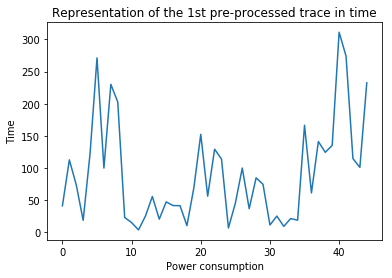

In [7]:
plot_1st_preproc_trace()

Each input 4-bit value is XOR'd with a 4-bit secret key (unknown). This is passed through an S-Box (a look-up table). The output of the S-Box will be used to check the guessed value of the key. In this step we will predict all possible values of y, by using in and guessing all the values of the 4-bit key chunk, k.

In [8]:
# Takes a 4-bit value of input and a 4-bit value of the hypothetical key
# Returns the output of the SBox
def SBox(in_val, key):
    return sbox[in_val ^ key]

In [9]:
# 4-bit to 4-bit S-box in PRESENT cipher
#       0   1   2   3   4   5   6   7   8   9   a   b   c   d   e   f
sbox= (0xc,0x5,0x6,0xb,0x9,0x0,0xa,0xd,0x3,0xe,0xf,0x8,0x4,0x7,0x1,0x2)

#### Construct the value-prediction matrix (No_inputs X No_keys)

Value-prediction matrix on variable y, using all possible 4-bit key candidates and all available 4-bit input values and S-box.
No need for power-prediction matrix, since we work under the identity leakage mode.

In [10]:
def get_value_prediction_matrix(no_inputs):
    # Initialize power prediction matrix
    power_pred = np.zeros(shape=(no_inputs, 16))

    for i in range(no_inputs):
        for key in range(0, 16):
            power_pred[i][key] = SBox(inputs[i][0], key)

    np.shape(power_pred)  
    
    return power_pred

In [11]:
power_pred = get_value_prediction_matrix(no_inputs)

In [12]:
power_pred

array([[ 7.,  4.,  2., ..., 12., 11.,  6.],
       [12.,  5.,  6., ...,  7.,  1.,  2.],
       [ 2.,  1.,  7., ...,  6.,  5., 12.],
       ...,
       [11.,  6.,  5., ...,  1.,  7.,  4.],
       [11.,  6.,  5., ...,  1.,  7.,  4.],
       [ 4.,  7.,  1., ...,  5.,  6., 11.]])

#### For all possible k candidates, compute the column-wise correlation between the traces matrix and the value-prediction matrix. Every guess will be compared to all traces.
#### Pearson Correlation Formula:
$ r = \frac{{}\sum_{i=1}^{n} (h_i - \overline{h})(t_i - \overline{t})}
{\sqrt{\sum_{i=1}^{n} (h_i - \overline{t})^2(t_i - \overline{t})^2}} $

Where: 
    <ul>
    <li> i - i iterates over the traces </li>
    <li> h - hypothetical values (from power prediction matrix) </li>
    <li> t - trace values (traces/ measurement matrix) </li>
    </ul>

We will use numpy.corrcoef to obtain the Pearson correlation coefficients.
Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html

<b>Assuming that $y_{0}$ leaks in sample $t_{i}$ and $y_{1}$ leaks in sample $t_{j}$ , then, sample $t_{i} ∗ t_{j}$ will correlate with the key-dependent value.</b>

In [13]:
def correlate_traces_with_hypotheses(traces, power_pred):
    no_col_traces = np.shape(traces)[1]
    no_col_power_pred = 16 # 16 key guesses (0..15)
    
    correlation = np.zeros(shape=(no_col_power_pred, no_col_traces))
    
    # Compute correlation between columns
    for power_pred_col in range(no_col_power_pred): # hypothetical values for the guess keys
        for traces_col in range(no_col_traces): # real values
            correlation[power_pred_col, traces_col] = np.corrcoef(power_pred[:,power_pred_col], traces[:,traces_col], rowvar=1)[0][1]
            
    return correlation   

In [14]:
# traces 2k X 10
np.shape(combined_traces)
# power_pred 2k X 16
np.shape(power_pred)

# absolute candidates 16 X 10
candidates = correlate_traces_with_hypotheses(combined_traces, power_pred)
abs_candidates = abs(candidates)

In [15]:
def get_top_candidate(candidates):       
    # The top candidate will be chosen based on absolute correlation.
    # The highest correlation reveals the actual KEY.
    candidates_max = np.zeros(16)
    
    # Only store the maximum cpa across all points in the trace 16 X 1
    for i in range(16):
        candidates_max[i] = max(candidates[i])
        
    # Rank the key candidates from best to worst, based on the absolute value of the correlation function.
    print('Top candidates: ', candidates_max.argsort()[::-1][:])
    
    # The highest correlation value reveals the key
    top_candidate_row = np.argmax(candidates_max)
    
    return top_candidate_row

In [16]:
top_candidate = get_top_candidate(abs_candidates)

Top candidates:  [ 3  6 11  0 14  9  5  8 10 12  1 15  2  4  7 13]


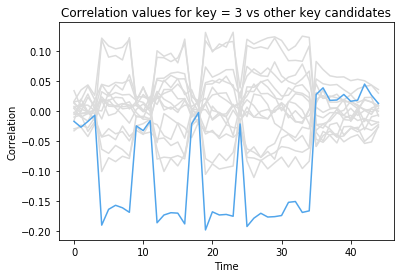

In [17]:
# For every time sample, plot the correlation value for every k candidate
plt.figure()

for i in range(np.shape(candidates)[0]): # 16 candidate keys
        if (i == top_candidate):
            plt.plot(candidates[i], color= '#51A5EB', zorder=2)
        else:
            plt.plot(candidates[i], color = '#DCDCDC', zorder=1)
        
plt.title("Correlation values for key = 3 vs other key candidates")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()

Since the correct key candidate corresponds to the highest absolute correlation value, the absolute correlation value will provide the best visual representation of the correct key.

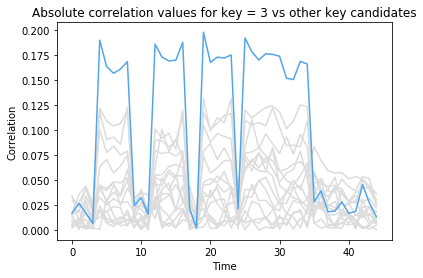

In [18]:
# For every time sample, plot the absolute correlation value for every k candidate
plt.figure()

for i in range(np.shape(abs_candidates)[0]): # 16 candidate keys
        if (i == top_candidate):
            plt.plot(abs_candidates[i], color= '#51A5EB', zorder=2)
        else:
            plt.plot(abs_candidates[i], color = '#DCDCDC', zorder=1)
        
plt.title("Absolute correlation values for key = 3 vs other key candidates")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()